In [3]:
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import math
import time

In [4]:
final_dataframes = pickle.load(open("final_dataframes.pkl", "rb"))

In [5]:
# Define the train ratio
train_ratio = 0.8  # 80% training data
df_dict = final_dataframes

# Split each DataFrame into training and testing parts based on time
df_dict_train = {}
df_dict_test = {}
for key, df in final_dataframes.items():
    n_time_steps = len(df['traffic_flow'])
    train_size = int(n_time_steps * train_ratio)
    df_train = df.iloc[:train_size].copy()
    df_test = df.iloc[train_size:].copy()
    df_dict_train[key] = df_train
    df_dict_test[key] = df_test


def create_sliding_window_data(df_dict, lookback, pred_horizon):
    X_dict = {}
    y_dict = {}
    for key, df in df_dict.items():
        node_series = df['traffic_flow'].values
        X_node = []
        y_node = []
        for i in range(len(node_series) - lookback - pred_horizon + 1):
            X_node.append(node_series[i:i + lookback])  # Input: Lookback window
            y_node.append(node_series[i + lookback:i + lookback + pred_horizon])  # Output: Next step(s)
        X_dict[key] = np.array(X_node)
        y_dict[key] = np.array(y_node)
    return X_dict, y_dict


# Sliding window parameters
lookback = 50  # Number of time steps to look back
pred_horizon = 1  # Predict the next time step

# Generate sliding window data for training and testing sets
X_train_dict, y_train_dict = create_sliding_window_data(df_dict_train, lookback, pred_horizon)
X_test_dict, y_test_dict = create_sliding_window_data(df_dict_test, lookback, pred_horizon)



In [6]:
def clean_graph(graph):
    # Remove self-loops
    graph = graph.copy()  # Avoid modifying the
    self_loops = list(nx.selfloop_edges(graph))
    graph.remove_edges_from(self_loops)
    
    # Remove duplicate edges (not necessary for undirected graphs in NetworkX)
    # Here just in case your graph is directed or you need further verification
    edges_to_remove = []
    for u, v, data in graph.edges(data=True):
        if graph.number_of_edges(u, v) > 1:  # More than one edge exists
            edges_to_remove.append((u, v))
    
    graph.remove_edges_from(edges_to_remove)
    largest_component = max(nx.connected_components(graph), key=len)
    graph = graph.subgraph(largest_component)

    print(f"Removed {len(self_loops)} self-loops and {len(edges_to_remove)} duplicate edges. Choose the Largest Component: {len(largest_component)} nodes.")
    # extract largest component

    return graph

def create_correlation_graph(df_dict, threshold=0.5, weighted=False, degree=4):
    """
    Create a correlation graph with a maximum degree constraint.
    """
    correlation_graph = nx.Graph()
    correlations_dict = {}

    # Add nodes to the graph
    for key, df in df_dict.items():
        correlation_graph.add_node(
            key, 
            x=df['Xkoordinat'].iloc[0], 
            y=df['Ykoordinat'].iloc[0], 
            traffic_flow=df['traffic_flow'].values
        )

    # Calculate correlations and store in a dictionary
    for key1, df1 in df_dict.items():
        for key2, df2 in df_dict.items():
            if key1 == key2:
                continue
            # Depending on split size only use test 
            correlation = np.corrcoef(df1['traffic_flow'], df2['traffic_flow'])[0, 1]
            correlations_dict[key1, key2] = correlation

    # Add edges based on correlation, enforcing degree constraint
    for key1 in df_dict.keys():
        # Sort potential connections by correlation (highest first)
        potential_edges = [
            (key2, correlations_dict[key1, key2])
            for key2 in df_dict.keys() if key1 != key2 and (key1, key2) in correlations_dict
        ]
        potential_edges = sorted(potential_edges, key=lambda x: -x[1])  # Sort by descending correlation
        
        for key2, corr in potential_edges:
            if correlation_graph.degree[key1] < degree and correlation_graph.degree[key2] < degree:
                if corr > threshold:
                    if weighted:
                        correlation_graph.add_edge(key1, key2, weight=corr)
                    else:
                        correlation_graph.add_edge(key1, key2)

    # Clean graph
    correlation_graph = clean_graph(correlation_graph)
    return correlation_graph, correlations_dict

def create_correlation_graph_edited(df_dict_full, df_dict_train, threshold=0.5, weighted=False,degree=4):
    """
    Create a correlation graph with a maximum degree constraint using only the training data for correlations.
    """
    correlation_graph = nx.Graph()
    correlations_dict = {}

    # Add nodes to the graph using the full data
    for key, df in df_dict_full.items():
        correlation_graph.add_node(
            key,
            x=df['Xkoordinat'].iloc[0],
            y=df['Ykoordinat'].iloc[0],
            traffic_flow=df['traffic_flow'].values  # Full traffic data
        )

    # Calculate correlations using the training data
    for key1, df1_train in df_dict_train.items():
        for key2, df2_train in df_dict_train.items():
            if key1 >= key2:  # Avoid duplicate computations
                continue
            correlation = np.corrcoef(df1_train['traffic_flow'], df2_train['traffic_flow'])[0, 1]
            correlations_dict[key1, key2] = correlation
            correlations_dict[key2, key1] = correlation  # Symmetric for undirected graph

    # Add edges based on correlation, enforcing degree constraint
    for key1 in df_dict_full.keys():
        # Sort potential connections by correlation (highest first)
        potential_edges = [
            (key2, correlations_dict[key1, key2])
            for key2 in df_dict_full.keys() if key1 != key2 and (key1, key2) in correlations_dict
        ]
        potential_edges = sorted(potential_edges, key=lambda x: -x[1])  # Sort by descending correlation

        for key2, corr in potential_edges:
            if correlation_graph.degree[key1] < degree and correlation_graph.degree[key2] < degree:
                if corr > threshold:
                    if weighted:
                        correlation_graph.add_edge(key1, key2, weight=corr)
                    else:
                        correlation_graph.add_edge(key1, key2)

    # Clean graph
    correlation_graph = clean_graph(correlation_graph)
    return correlation_graph, correlations_dict

def create_distance_graph(df_dict, weighted=False, degree=4):
    """
    Create a distance graph with a maximum degree constraint.
    """
    distance_graph = nx.Graph()
    distance_dict = {}

    # Add nodes to the graph
    for key, df in df_dict.items():
        distance_graph.add_node(
            key, 
            x=df['Xkoordinat'].iloc[0], 
            y=df['Ykoordinat'].iloc[0], 
            traffic_flow=df['traffic_flow'].values
        )

    # Calculate distances and store in a dictionary
    for key1, df1 in df_dict.items():
        for key2, df2 in df_dict.items():
            if key1 == key2:
                continue
            idx = df1['traffic_flow'].first_valid_index()
            distance = math.sqrt(
                (df1['Xkoordinat'][idx] - df2['Xkoordinat'][idx])**2 +
                (df1['Ykoordinat'][idx] - df2['Ykoordinat'][idx])**2
            )
            distance_dict[key1, key2] = distance

    # Add edges based on distance, enforcing degree constraint
    threshold = (sum(distance_dict.values()) / len(distance_dict)) * 2  # Distance threshold
    for key1 in df_dict.keys():
        # Sort potential connections by distance (shortest first)
        potential_edges = [
            (key2, distance_dict[key1, key2])
            for key2 in df_dict.keys() if key1 != key2 and (key1, key2) in distance_dict
        ]
        potential_edges = sorted(potential_edges, key=lambda x: x[1])  # Sort by ascending distance
        
        for key2, dist in potential_edges:
            if distance_graph.degree[key1] < degree and distance_graph.degree[key2] < degree:
                if dist < threshold:
                    if weighted:
                        max_distance = max(distance_dict.values())
                        min_distance = min(distance_dict.values())
                        normalised_distance = (dist - min_distance) / (max_distance - min_distance)
                        distance_graph.add_edge(key1, key2, weight=normalised_distance)
                    else:
                        distance_graph.add_edge(key1, key2)

    # Clean graph
    distance_graph = clean_graph(distance_graph)
    return distance_graph, distance_dict

def create_fully_connected_graph(df_dict):
    # Connect every node to every other node without weights 
    fully_connected_graph = nx.complete_graph(len(df_dict))

    # Add attributes to the nodes
    for i, (key, df) in enumerate(df_dict.items()):
        fully_connected_graph.nodes[i]['x'] = df['Xkoordinat'].iloc[0]
        fully_connected_graph.nodes[i]['y'] = df['Ykoordinat'].iloc[0]
        fully_connected_graph.nodes[i]['traffic_flow'] = df['traffic_flow'].values
        
    return fully_connected_graph

def create_fully_connected_graph_RANDOM_WEIGHTS(df_dict):
    # Connect every node to every other node without weights 
    fully_connected_graph = nx.complete_graph(len(df_dict))

    # Add attributes to the nodes
    for i, (key, df) in enumerate(df_dict.items()):
        fully_connected_graph.nodes[i]['x'] = df['Xkoordinat'].iloc[0]
        fully_connected_graph.nodes[i]['y'] = df['Ykoordinat'].iloc[0]
        fully_connected_graph.nodes[i]['traffic_flow'] = df['traffic_flow'].values

    # Add random weights to the edges
    for u, v in fully_connected_graph.edges:
        fully_connected_graph[u][v]['weight'] = np.random.rand()
        
    return fully_connected_graph, nx.get_edge_attributes(fully_connected_graph, 'weight')

distance_graph_weighted, distance_dict = create_distance_graph(final_dataframes, weighted=True, degree=4)
distance_graph_unweighted, _ = create_distance_graph(final_dataframes, weighted=False, degree=4)


correlation_graph_weighted, correlation_dict = create_correlation_graph(final_dataframes, threshold=0.7, weighted=True, degree=20)
correlation_graph_weighted_edited, correlation_dict_edited = create_correlation_graph_edited(df_dict_full=df_dict, df_dict_train=df_dict_train, threshold=0.7, weighted=True, degree=20)


correlation_graph_unweighted, _ = create_correlation_graph(final_dataframes, threshold=0.7, weighted=False, degree=20)
correlation_graph_unweighted_edited, _ = create_correlation_graph_edited(df_dict_full=df_dict, df_dict_train=df_dict_train, threshold=0.7, weighted=False, degree=20)

fully_connected_graph = create_fully_connected_graph(final_dataframes)
fully_connected_graph_RANDOM_WEIGHTS, fully_connected_weights = create_fully_connected_graph_RANDOM_WEIGHTS(final_dataframes)


Removed 0 self-loops and 0 duplicate edges. Choose the Largest Component: 26 nodes.
Removed 0 self-loops and 0 duplicate edges. Choose the Largest Component: 26 nodes.
Removed 0 self-loops and 0 duplicate edges. Choose the Largest Component: 25 nodes.
Removed 0 self-loops and 0 duplicate edges. Choose the Largest Component: 25 nodes.
Removed 0 self-loops and 0 duplicate edges. Choose the Largest Component: 25 nodes.
Removed 0 self-loops and 0 duplicate edges. Choose the Largest Component: 25 nodes.


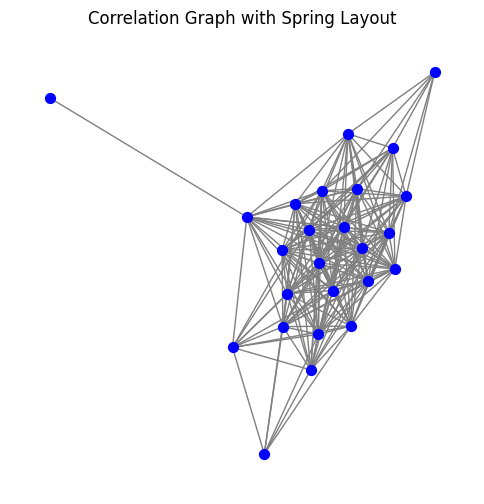

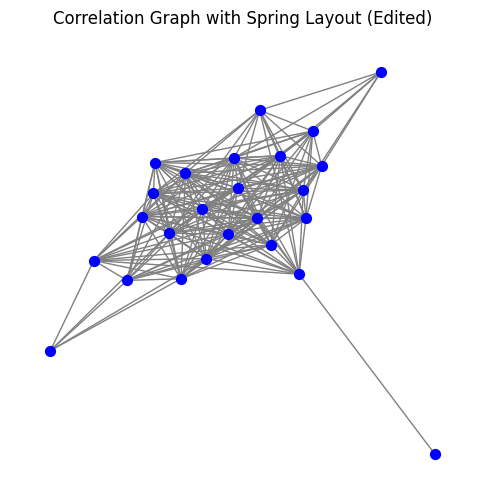

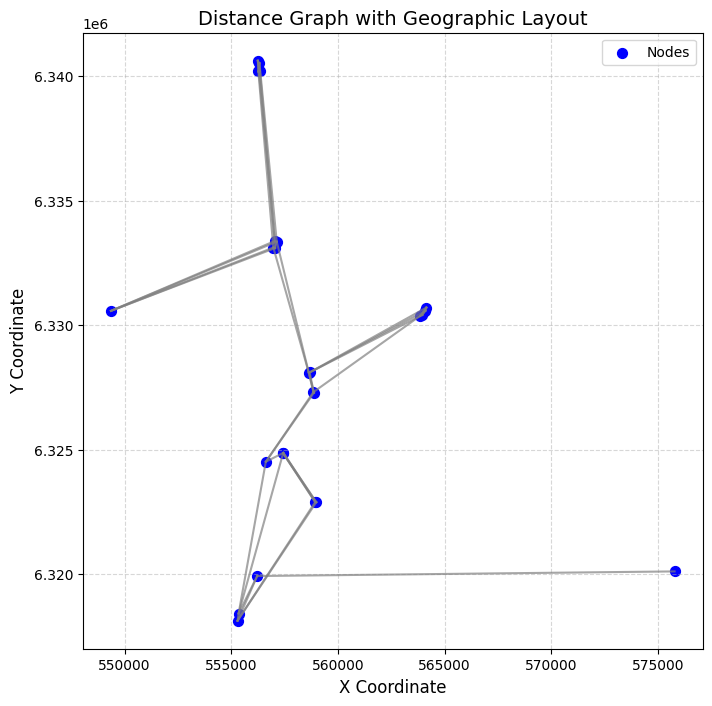

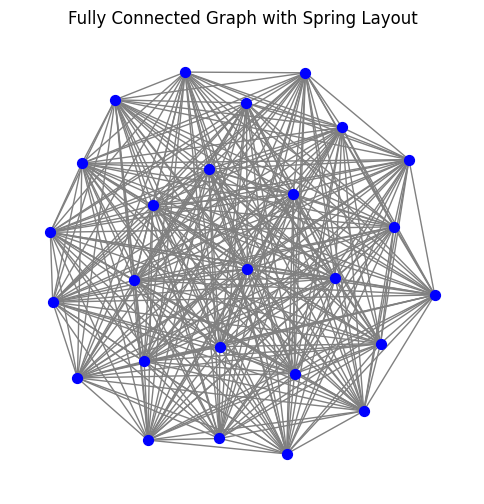

In [8]:
# Plot the Correlation graph without labels or edge attributes, use a spring layout, with a title that explain how they where plotted
plt.figure(figsize=(6, 6))
plt.title("Correlation Graph with Spring Layout")
pos = nx.spring_layout(correlation_graph_weighted)
nx.draw(correlation_graph_weighted, pos, with_labels=False, node_size=50, node_color='blue', edge_color='gray')
plt.show()


# Plot the Correlation graph without labels or edge attributes, use a spring layout, with a title that explain how they where plotted
plt.figure(figsize=(6, 6))
plt.title("Correlation Graph with Spring Layout (Edited)")
pos = nx.spring_layout(correlation_graph_weighted_edited)
nx.draw(correlation_graph_weighted_edited, pos, with_labels=False, node_size=50, node_color='blue', edge_color='gray')
plt.show()


# Extract positions from the graph's node attributes
pos = {node: (data['x'], data['y']) for node, data in distance_graph_weighted.nodes(data=True)}
x_values = [coord[0] for coord in pos.values()]
y_values = [coord[1] for coord in pos.values()]
plt.figure(figsize=(8, 8))
plt.title("Distance Graph with Geographic Layout", fontsize=14)


plt.grid(True, linestyle='--', alpha=0.5)
plt.scatter(x_values, y_values, c='blue', s=50, label='Nodes')
for edge in distance_graph_weighted.edges():
    x_coords = [pos[edge[0]][0], pos[edge[1]][0]]
    y_coords = [pos[edge[0]][1], pos[edge[1]][1]]
    plt.plot(x_coords, y_coords, color='gray', alpha=0.7)
plt.xlabel("X Coordinate", fontsize=12)
plt.ylabel("Y Coordinate", fontsize=12)
plt.legend()
plt.show()


# Plot the Correlation graph without labels or edge attributes, use a spring layout, with a title that explain how they where plotted
plt.figure(figsize=(6, 6))
plt.title("Fully Connected Graph with Spring Layout")
pos = nx.spring_layout(fully_connected_graph)
nx.draw(fully_connected_graph, pos, with_labels=False, node_size=50, node_color='blue', edge_color='gray')
plt.show()

Pytorch

In [10]:
import torch
import numpy as np
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.model_selection import train_test_split

In [11]:
# Define GNN model
class Baseline(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.fc(x)
        return x
    

# Define GNN model
class TrafficGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.fc = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = self.fc(x)
        return x

In [16]:
def create_sliding_window_data(df_dict, lookback, pred_horizon):
    X_dict = {}
    y_dict = {}
    for key, df in df_dict.items():
        node_series = df['traffic_flow'].values
        X_node = []
        y_node = []
        for i in range(len(node_series) - lookback - pred_horizon + 1):
            X_node.append(node_series[i:i + lookback])  # Input: Lookback window
            y_node.append(node_series[i + lookback:i + lookback + pred_horizon])  # Output: Next step(s)
        X_dict[key] = np.array(X_node)
        y_dict[key] = np.array(y_node)
    return X_dict, y_dict


In [17]:
# Sliding window parameters
lookback = 50  # Number of time steps to look back
pred_horizon = 1  # Predict the next time step

# Generate sliding window data for training and testing sets
X_train_dict, y_train_dict = create_sliding_window_data(df_dict_train, lookback, pred_horizon)
X_test_dict, y_test_dict = create_sliding_window_data(df_dict_test, lookback, pred_horizon)

# Combine data from all nodes
X_train_list = []
y_train_list = []
for key in X_train_dict:
    X_train_list.append(X_train_dict[key])
    y_train_list.append(y_train_dict[key])

X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)

X_test_list = []
y_test_list = []
for key in X_test_dict:
    X_test_list.append(X_test_dict[key])
    y_test_list.append(y_test_dict[key])

X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)

X_test = torch.tensor(X_test, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

# Prepare graph edges with integer mapping
node_mapping = {node: idx for idx, node in enumerate(correlation_graph_weighted.nodes())}

edge_index = torch.tensor(
    [[node_mapping[edge[0]], node_mapping[edge[1]]] for edge in correlation_graph_weighted.edges],
    dtype=torch.long
).t().contiguous()

# Create PyTorch Geometric Data objects
train_data = Data(x=X_train, edge_index=edge_index, y=y_train.view(-1, pred_horizon))
val_data = Data(x=X_val, edge_index=edge_index, y=y_val.view(-1, pred_horizon))
test_data = Data(x=X_test, edge_index=edge_index, y=y_test.view(-1, pred_horizon))

Test Everything

In [ ]:
def create_sliding_window_data(df_dict, lookback, pred_horizon):
    X_dict = {}
    y_dict = {}
    for key, df in df_dict.items():
        node_series = df['traffic_flow'].values
        X_node = []
        y_node = []
        for i in range(len(node_series) - lookback - pred_horizon + 1):
            X_node.append(node_series[i:i + lookback])  # Input: Lookback window
            y_node.append(node_series[i + lookback:i + lookback + pred_horizon])  # Output: Next step(s)
        X_dict[key] = np.array(X_node)
        y_dict[key] = np.array(y_node)
    return X_dict, y_dict


In [ ]:
def split_dataframes(df_dict, train_ratio=0.7):
    """
    Splits each DataFrame in df_dict into training and testing parts based on time indices.

    Returns:
        df_dict_train: Dictionary of training DataFrames.
        df_dict_test: Dictionary of testing DataFrames.
    """
    df_dict_train = {}
    df_dict_test = {}
    for key, df in df_dict.items():
        n_time_steps = len(df['traffic_flow'])
        train_size = int(n_time_steps * train_ratio)
        df_train = df.iloc[:train_size].copy()
        df_test = df.iloc[train_size:].copy()
        df_dict_train[key] = df_train
        df_dict_test[key] = df_test
    return df_dict_train, df_dict_test

def create_sliding_window_data_per_node(df_dict, lookback, pred_horizon):
    """
    Creates sliding window data for each node.

    Returns:
        X_dict: Dictionary mapping node keys to input sequences.
        y_dict: Dictionary mapping node keys to target sequences.
    """
    X_dict = {}
    y_dict = {}
    for key, df in df_dict.items():
        node_series = df['traffic_flow'].values
        X_node = []
        y_node = []
        for i in range(len(node_series) - lookback - pred_horizon + 1):
            X_node.append(node_series[i:i + lookback])  # Input: Lookback window
            y_node.append(node_series[i + lookback:i + lookback + pred_horizon])  # Output: Next step(s)
        X_dict[key] = np.array(X_node)
        y_dict[key] = np.array(y_node)
    return X_dict, y_dict

def combine_node_data(X_dict, y_dict):
    """
    Combines data from all nodes.

    Returns:
        X_combined: Combined input sequences from all nodes.
        y_combined: Combined target sequences from all nodes.
    """
    X_list = []
    y_list = []
    for key in X_dict:
        X_list.append(X_dict[key])
        y_list.append(y_dict[key])
    X_combined = np.concatenate(X_list, axis=0)
    y_combined = np.concatenate(y_list, axis=0)
    return X_combined, y_combined

def convert_to_tensors_and_split(X, y, val_ratio=0.1, random_state=42):
    """
    Converts data to PyTorch tensors and splits into train and validation sets.

    Returns:
        X_train: Training input tensor.
        X_val: Validation input tensor.
        y_train: Training target tensor.
        y_val: Validation target tensor.
    """
    # Convert to PyTorch tensors
    X_tensor = torch.tensor(X, dtype=torch.float)
    y_tensor = torch.tensor(y, dtype=torch.float)

    # Split into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_tensor, y_tensor, test_size=val_ratio, random_state=random_state
    )
    return X_train, X_val, y_train, y_val

def prepare_pyg_data(X_train, y_train, X_val, y_val, X_test, y_test, edge_index, pred_horizon):
    """
    Prepares PyTorch Geometric Data objects for training, validation, and testing.

    Returns:
        train_data: Data object for training.
        val_data: Data object for validation.
        test_data: Data object for testing.
    """
    train_data = Data(x=X_train, edge_index=edge_index, y=y_train.view(-1, pred_horizon))
    val_data = Data(x=X_val, edge_index=edge_index, y=y_val.view(-1, pred_horizon))
    test_data = Data(x=X_test, edge_index=edge_index, y=y_test.view(-1, pred_horizon))
    return train_data, val_data, test_data

train_ratio = 0.7  # 70% training data


df_dict_train, df_dict_test = split_dataframes(final_dataframes, train_ratio)

# Models to evaluate
graph_models = {
    #"Distance_Weighted": lambda: create_distance_graph(final_dataframes, weighted=True),
    #"Distance_Unweighted": lambda: create_distance_graph(final_dataframes, weighted=False),
    "Correlation_Weighted": lambda: create_correlation_graph(final_dataframes, threshold=0.6, weighted=True),
    "Correlation_Weighted_edited" : lambda: create_correlation_graph_edited(df_dict_full=df_dict, df_dict_train=df_dict_train, threshold=0.6, weighted=True),
    "Correlation_Unweighted": lambda: create_correlation_graph(final_dataframes, threshold=0.6, weighted=False),
    "Correlation_Unweighted_edited" : lambda: create_correlation_graph_edited(df_dict_full=df_dict, df_dict_train=df_dict_train, threshold=0.6, weighted=False),
    #"Fully_Connected": lambda: (create_fully_connected_graph(final_dataframes), None),
    #"Fully_Connected_random_weights": lambda: (create_fully_connected_graph_RANDOM_WEIGHTS(final_dataframes))
}

# Initialize results dictionary
results = {}

# Model parameters
hc = 32
lookback = 50
pred_horizon = 1

# Train and evaluate each model
for model_name, graph_fn in graph_models.items():
    print(f"Running model: {model_name}")
    
    # Create graph and prepare data
    graph, _ = graph_fn()
    node_mapping = {node: idx for idx, node in enumerate(graph.nodes())}
    
    edge_index = torch.tensor(
        [[node_mapping[edge[0]], node_mapping[edge[1]]] for edge in graph.edges],
        dtype=torch.long
    ).t().contiguous()
    
    # Create sliding window data per node for training and testing
    X_train_dict, y_train_dict = create_sliding_window_data_per_node(df_dict_train, lookback, pred_horizon)
    X_test_dict, y_test_dict = create_sliding_window_data_per_node(df_dict_test, lookback, pred_horizon)
    
    # Combine data from all nodes
    X_train, y_train = combine_node_data(X_train_dict, y_train_dict)
    X_test, y_test = combine_node_data(X_test_dict, y_test_dict)
    
    # Convert to tensors and split training data into train and validation sets
    X_train, X_val, y_train, y_val = convert_to_tensors_and_split(X_train, y_train, val_ratio=0.1, random_state=42)
    
    # Convert test data to tensors
    X_test = torch.tensor(X_test, dtype=torch.float)
    y_test = torch.tensor(y_test, dtype=torch.float)
    
    print(f"{model_name} - Training samples: {X_train.shape[0]}")
    print(f"{model_name} - Validation samples: {X_val.shape[0]}")
    print(f"{model_name} - Test samples: {X_test.shape[0]}")
    
    # Prepare PyTorch Geometric Data objects
    train_data, val_data, test_data = prepare_pyg_data(X_train, y_train, X_val, y_val, X_test, y_test, edge_index, pred_horizon)
    
    # Initialize model
    model = TrafficGCN(in_channels=lookback, hidden_channels=hc, out_channels=pred_horizon)
    optimizer = Adam(model.parameters(), lr=0.0001)
    criterion = torch.nn.MSELoss()
    
    # Train model
    train_losses = []
    val_losses = []
    for epoch in range(100):
        optimizer.zero_grad()
        
        # Training
        model.train()
        out = model(train_data)
        train_loss = criterion(out, train_data.y)
        train_loss.backward()
        optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_out = model(val_data)
            val_loss = criterion(val_out, val_data.y)
        
        # Track losses
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        
        if epoch % 10 == 0:
            print(f"{model_name} - Epoch {epoch}: Train Loss: {train_loss.item()}, Val Loss: {val_loss.item()}")
    
    # Evaluate on test data
    model.eval()
    with torch.no_grad():
        test_out = model(test_data)
        test_loss = criterion(test_out, test_data.y)
        actual_values = test_data.y.cpu().numpy()
        predicted_values = test_out.cpu().numpy()
    
    print(f"{model_name} - Test Loss: {test_loss.item()}")
    
    # Save results
    results[model_name] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "test_loss": test_loss.item(),
        "actual_values": actual_values,
        "predicted_values": predicted_values
    }


Running model: Correlation_Weighted
Removed 0 self-loops and 0 duplicate edges. Choose the Largest Component: 25 nodes.
Correlation_Weighted - Training samples: 563097
Correlation_Weighted - Validation samples: 62567
Correlation_Weighted - Test samples: 267410
Correlation_Weighted - Epoch 0: Train Loss: 2904.06640625, Val Loss: 2865.477783203125
Correlation_Weighted - Epoch 10: Train Loss: 2500.2392578125, Val Loss: 2462.36083984375
